# Iris dataset - Regressão Logística - 3 classes

## Objetivos

Este notebook ilustra o problema de classificação.

O objetivo é classificar as amostras da Íris em 3 classes.
- o alvo é o índice da classe: 0, 1 ou 2
- função de perda é Entropia Cruzada
- rede é uma camada densa linear com duas entradas e três saídas (n. de classes)

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmax_CrossEntropy_Otimizacao.png)

## Importação das bibliotecas

In [1]:
%matplotlib inline
import os
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from IPython import display

## Dataset: Leitura, normalização e visualização dos dados

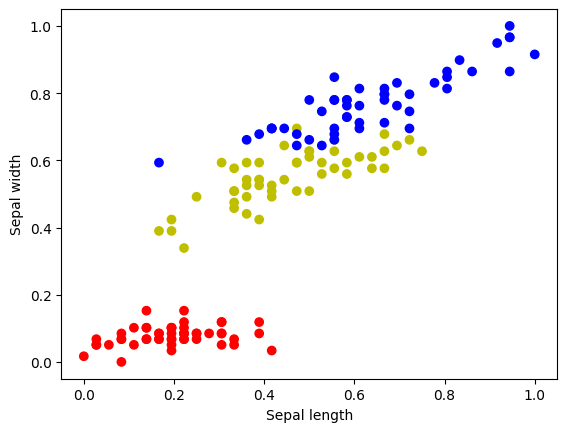

In [41]:
iris = load_iris()
X = iris.data[:,::2]  # comprimento das sépalas e pétalas, indices 0 e 2
# normalização (mix_max scaling)
Xc = X - X.min(axis=0)
Xs = Xc.max(axis=0)
Xc = Xc/Xs

Y = iris.target # Target são as classes 0, 1 ou 2 (até então, era apenas a 1)
colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [42]:
X_tensor = torch.FloatTensor(Xc)  # Entrada é FloatTensor
Y_tensor = torch.LongTensor(Y)    # Classe é LongTensor

In [43]:
Y_tensor

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

## Construindo o modelo da rede

A saída da rede é composta por um neurônio para cada classe. A saída é denominada *scores* ou logitos:

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoLogisticaRede_2_3.png)

In [44]:
model = nn.Linear(2,3)  # 2 entradas e 3 saídas

In [45]:
model.state_dict()

OrderedDict([('weight',
              tensor([[ 0.3633,  0.6417],
                      [-0.6463,  0.3301],
                      [-0.0892,  0.2740]])),
             ('bias', tensor([-0.1366, -0.6973, -0.0846]))])

### Fazendo um predict

In [46]:
out = model(Variable(X_tensor[:4,:])) # Predição para 4 amostras
out

tensor([[-0.0124, -0.8186, -0.0858],
        [-0.0326, -0.7827, -0.0809],
        [-0.0636, -0.7523, -0.0806],
        [-0.0520, -0.7232, -0.0688]], grad_fn=<AddmmBackward0>)

In [47]:
oo = F.softmax(out,dim=1) # Função de ativação softmax: Aplica a função linha a linha, transformando os 3 logits em probabilidades que somam 1
oo

tensor([[0.4209, 0.1880, 0.3911],
        [0.4123, 0.1948, 0.3929],
        [0.4023, 0.2021, 0.3956],
        [0.4009, 0.2049, 0.3942]], grad_fn=<SoftmaxBackward0>)

### Calculando as probabilidades com Softmax

- [Wikipedia:Softmax_function](https://en.wikipedia.org/wiki/Softmax_function)

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/softmax.png)

In [48]:
F.softmax(out,dim=1)*100 

tensor([[42.0916, 18.7967, 39.1117],
        [41.2339, 19.4760, 39.2901],
        [40.2341, 20.2065, 39.5594],
        [40.0896, 20.4890, 39.4214]], grad_fn=<MulBackward0>)

### Predição da classe

In [49]:
prob,y_pred = torch.max(F.softmax(out,dim=1),dim=1)
print(y_pred) # Índice de maior probabilidade -> classe predita
print(prob) # Valor de maior probabilidade -> confiança

tensor([0, 0, 0, 0])
tensor([0.4209, 0.4123, 0.4023, 0.4009], grad_fn=<MaxBackward0>)


## Treinamento

### Classe para visualização dinâmica

In [50]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

def predict_prob(model, inputs):
    outputs = model(Variable(inputs))
    outputs = F.softmax(outputs,dim=1)
    predicts, _ = torch.max(outputs, 1)

    return predicts.data.numpy()

class MyPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(12, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 3, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.set_title('Perda x Época')
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 3, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)
        self.ax2.set_title('Fronteiras de decisão')

        self.ax3 = self.fig.add_subplot(1, 3, 3)
        self.ax3.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax3.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax3.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax3.set_ylabel('Largura da Sepala')#,fontsize=28)
        self.ax3.set_title('Máxima probabilidade')

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                #Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
                Zc = predict(self.model,torch.FloatTensor(self.X_grid))
                Zc = Zc.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Zc, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                Zp = predict_prob(self.model,torch.FloatTensor(self.X_grid))
                Zp = Zp.reshape(self.xx.shape)

                self.ax3.pcolormesh(self.xx, self.yy, Zp, cmap=plt.cm.magma)
                colors = np.array(['r','y','b'])
                self.ax3.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

### Laço principal de treinamento da Regressão Logística por Softmax

In [51]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

Final loss: 0.1563507616519928


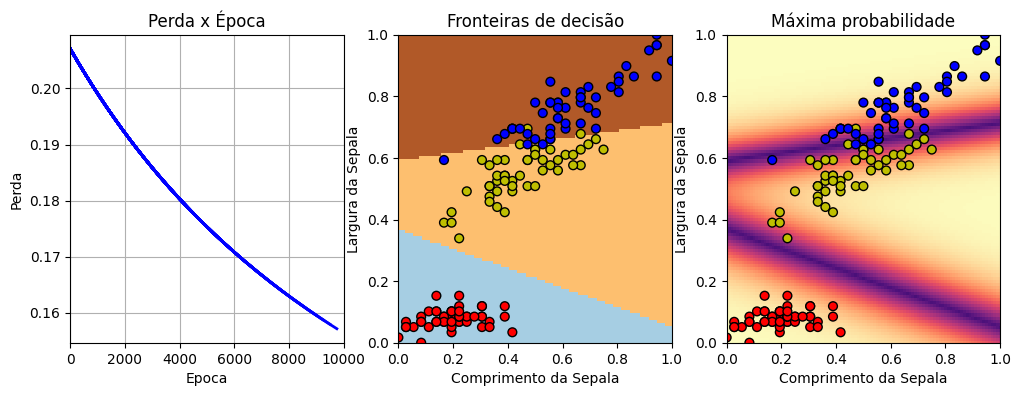

In [60]:
nb_epoch = 10000

#Definindo o plotter
my_plot = MyPlotter(model, Xc, Y, nb_epoch)

losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    # calcula a perda
    loss = criterion(output, Variable(Y_tensor))

    # Faz o backpropagation para calcular os gradientes e otimizar parâmetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data.item())

    my_plot.on_epoch_end(i, {'loss': loss.data.item()});
    final_loss = loss.data.item()

print('Final loss:', final_loss)

## Avaliação

### Parâmetros após treinamento

In [53]:
model.state_dict()

OrderedDict([('weight',
              tensor([[ -3.0369, -14.3088],
                      [  1.5793,  -0.2308],
                      [  1.0854,  15.7853]])),
             ('bias', tensor([ 6.6725,  1.3269, -8.9178]))])

### Salvando os parâmetros treinados

In [54]:
os.makedirs('../models',exist_ok=True)
torch.save(model.state_dict(),'../models/RegrLog_Iris.pt')

In [55]:
! ls ../models/

'ls' nÆo ‚ reconhecido como um comando interno
ou externo, um programa oper vel ou um arquivo em lotes.


In [56]:
nn.init.constant(model.weight,0)
model.state_dict()

C:\Users\mathe\AppData\Local\Temp\ipykernel_40576\952960416.py:1: FutureWarning: `nn.init.constant` is now deprecated in favor of `nn.init.constant_`.
  nn.init.constant(model.weight,0)


OrderedDict([('weight',
              tensor([[0., 0.],
                      [0., 0.],
                      [0., 0.]])),
             ('bias', tensor([ 6.6725,  1.3269, -8.9178]))])

### Recuperando os pesos salvos

In [57]:
param_saved = torch.load('../models/RegrLog_Iris.pt')
model.load_state_dict(param_saved)
model.state_dict()

OrderedDict([('weight',
              tensor([[ -3.0369, -14.3088],
                      [  1.5793,  -0.2308],
                      [  1.0854,  15.7853]])),
             ('bias', tensor([ 6.6725,  1.3269, -8.9178]))])

### Exatidão (acurácia) do classificador

Acurácia indica o número de acertos sobre o número total de amostras

In [58]:
Y_pred = predict(model, X_tensor)
accuracy = (Y_pred == Y).mean()
print('Training Accuracy: ', accuracy)

Training Accuracy:  0.96


### Matriz de confusão

In [59]:
import pandas as pd
pd.crosstab(Y_pred, Y)

col_0,0,1,2
row_0,,,
0,50,0,0
1,0,47,3
2,0,3,47


## Atividades

### Perguntas:

1. Observe que se após o treinamento, a célula for executada novamente, ela continua utilizando os parâmetros treinados até sua última execução. O que é preciso fazer para que o treinamento comece deste o início, como da primeira vez que foi executado?
- Quando a célula é executada novamente após o treino, o modelo já está com pesos atualizados pela execução anterior. Logo, o treinamento continua de onde parou, a menos que seja reinicializado explicitamente

3. Experimente refazer o treinamento com diferentes valores de learning rate

### Exercícios:

1. Observando o gráfico de máxima probabilidade, responda:
   - O visual do gráfico ajuda muito na sua interpretação, pois fica claro:
     - Fundo amarelo claro: alta probabilidade para a classe predita
     - Fundo roxo escuro: baixa probabilidade
     - Pontos com borda preta: amostras reais
     - cores dos pontos: representam as classes (setosa, versicolor e virginica)
    1. Qual é a amostra classificada corretamente, com maior probabilidade?
       - Amostra vermelha no canto inferior esquerdo
    2. Qual é a amostra classificada erradamente, com maior probabilidade?
       - Amostra amarela classificada como azul, sobre fundo claro
    3. Qual é a amostra classificada corretamente, com menor probabilidade?
       - Amostra azul no topo direito sobre fundo escuro 
    4. Qual é a amostra classificada erradamente, com menor probabilidade?
       - Amostra amarela em zona de transição escura entre duas classes — erro com baixa probabilidade
3. Quantos parâmetros possui esta rede? Quantos são da camada densa e quantos são de bias?
   - model=nn.Linear(2,3) -> 2 entradas e 3 saídas. Cada camada tem 6 pesos e 3 biasm totalizando 9 parâmetros treináveis
4. Quantas entradas e quantas saídas esta rede possui?
   - 2 entradas: comprimento da sépala e da pétala e 3 saídas: uma para cada classe (setosa, versicolor e virginica)
5. Como se pode calcular a acurácia a partir da matriz de confusão?
   - acuracia = (total de acertos)/(total de amostras) = (somatorio diagonal princiapl)/(soma total da matriz)
6. O que faz a função `torch.max`? Quantos parâmetros ela retorna e quais seus significados?
   - Retorna dois tensores, o valor máximo ao longo do eixo dim e o índice do valor máximo ao longo do eixo dim
    - http://pytorch.org/docs/master/torch.html?highlight=torch%20max#torch.max

## Principais aprendizados

Este notebook, como vem sendo com os demais, é mais uma etapa de consolidação na construção de redes neurais com o pytorch. Diferentemente dos notebooks anteriores, que trabalhavam com uma única classe e se concentravam em regressão linear sem função de ativação - aqui foi explorado um problema completo de classificação multiclasse, aplicando softmax e cross entropy, além de uma visualização interativa.
A maior novidade aqui, além dos novos métodos e funções do pytorch, como nn.CrossEntropy e F.softmax, foi a integração de ferramentas para salvar modelos treinados, visualizar as fronteiras de decisão e a interpretação do modelo pela matriz de confusão